In [1]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
import glob
from xml.etree import ElementTree as ETree
import random
import pandas as pd

In [2]:
images = glob.glob('data/archive/images/*.png')
annots = glob.glob('data/archive/annotations/*.xml')

In [3]:
def parse_xml(xml_files):
    annots_info = []
    for xml_file in xml_files:
        root = ETree.parse(xml_file)
        filename = root.find('filename').text
        width = int(root.find('size')[0].text)
        height = int(root.find('size')[1].text)
        for member in root.findall('object'):
            label = member[0].text
            occulded = int(member[4].text)
            xmin, ymin, xmax ,ymax = [int(member[5][i].text) for i in range(4)]

            annots_info.append({
                'file_name': filename,
                'label': label,
                'width': width,
                'height': height,
                'occculded': occulded,
                'coords': [xmin, ymin, xmax, ymax]
            })
    
    return pd.DataFrame(annots_info, columns=list(annots_info[0].keys()))

In [4]:
df = parse_xml(annots)

# Visualize data

In [5]:
def autolabel(rects):
    """
    Attach a text label above each bar displaying its height
    """
    for rect in rects:
        height = rect.get_height()
        plt.text(rect.get_x() + rect.get_width()/2., 1.01*height,
                '%d' % int(height),
                ha='center', va='bottom')

In [6]:
labels = df['label'].unique().tolist()
val_counts = df.groupby('label').count()['file_name'].values

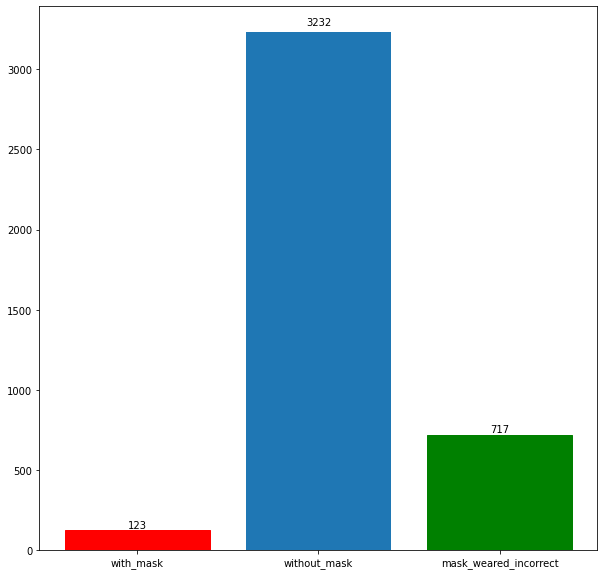

In [7]:
# Very big class imbalance - probably need to use focal loss
plt.figure(figsize=(10, 10))
bar = plt.bar(labels, val_counts)
autolabel(bar)
bar[0].set_color('r')
bar[2].set_color('g')

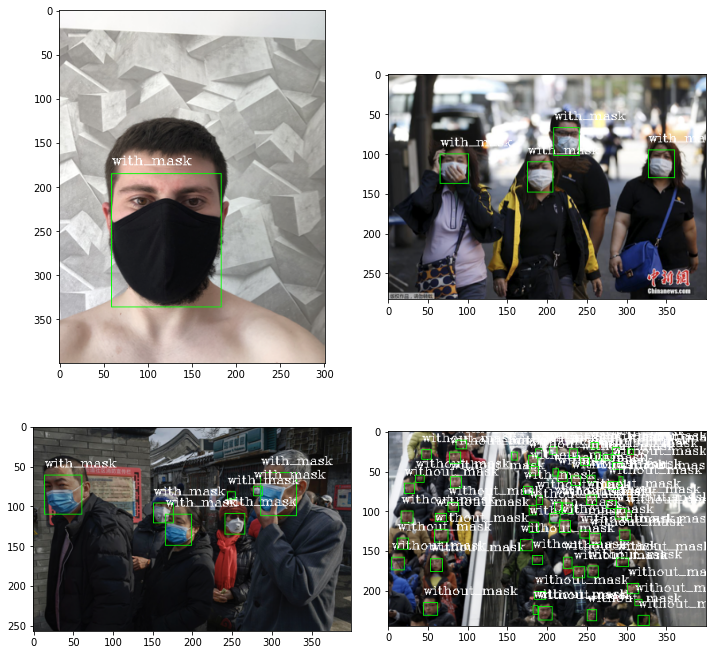

In [8]:
# Lets visualize the images
sample = df['file_name'].sample(n=4)

row, columns = 2, 2
count = 0

plt.figure(figsize=(10, 10))
for index, filename in sample.iteritems():
    file_data = df[df['file_name'] == filename]
    image_path = 'data/archive/images/' + filename
    img = cv2.imread(image_path)
    
    for index, data in file_data.iterrows():
        xmin, ymin, xmax ,ymax = data['coords']

        cv2.rectangle(img, (xmin, ymin), (xmax, ymax), (0, 255, 0), 1)
        cv2.putText(img, data['label'], (xmin, ymin - 10), cv2.FONT_HERSHEY_COMPLEX, 0.5, (255, 255, 255), 1)

    count += 1
    plt.subplot(row, columns, count)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

plt.tight_layout()

# Cropped Examples
- Lets get an example of each class by:
    - cropping out
    - visualizing

In [30]:
labels = df['label'].unique()

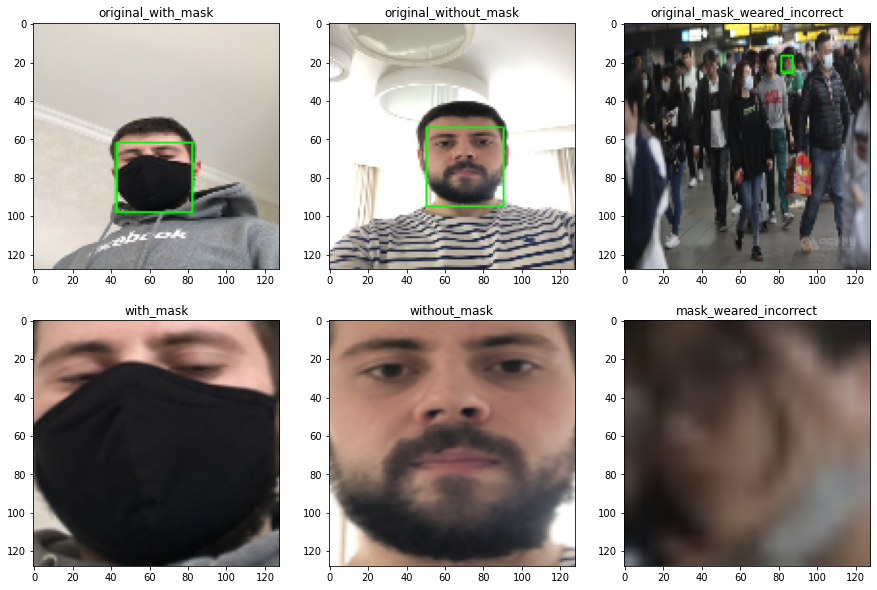

In [80]:
plt.figure(figsize=(15, 10))

for index, label in enumerate(labels):
    selected_row = df[df['label'] == label].sample()
    image_path = 'data/archive/images/' + selected_row.iloc[0]['file_name']
    img = cv2.imread(image_path)
    xmin, ymin, xmax ,ymax = selected_row.iloc[0]['coords']
    
    rec_image = cv2.rectangle(img.copy(), (xmin, ymin), (xmax, ymax), (0, 255, 0), 2)
    cropped_img = cv2.resize(img[ymin:ymax, xmin:xmax], (128, 128))
        
    plt.subplot(2, 3, index + 1)
    plt.title('original_' + label)
    plt.imshow(cv2.cvtColor(cv2.resize(rec_image, (128, 128)), cv2.COLOR_BGR2RGB))
    
    plt.subplot(2, 3, index + 3 + 1)
    plt.title(label)
    plt.imshow(cv2.cvtColor(cropped_img, cv2.COLOR_BGR2RGB))